In [4]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import kpss
import itertools
from datetime import timedelta
from pmdarima.arima.utils import nsdiffs
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# turn off warnings
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tools.sm_exceptions import InterpolationWarning

warnings.filterwarnings('ignore', category=InterpolationWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [5]:
# Create a date range for one year (e.g., 2020)
dates = pd.date_range(start='2020-01-01', end='2020-12-31', freq='D')

# Define units and shifts (each combination will represent a separate series)
units = ['Unit1', 'Unit2']
shifts = ['Morning', 'Evening']

data_list = []

# Loop through each combination and each date
for unit in units:
    for shift in shifts:
        # Define a different trend or base sales for each unit/shift if desired
        # Here, we use a simple example where trend intensity varies by combination.
        if unit == 'Unit1' and shift == 'Morning':
            base, trend_factor = 100, 0.1
        elif unit == 'Unit1' and shift == 'Evening':
            base, trend_factor = 120, 0
        elif unit == 'Unit2' and shift == 'Morning':
            base, trend_factor = 90, 0.15
        else:  # Unit2, Evening
            base, trend_factor = 110, 0.25
        
        for date in dates:
            weekday = date.day_name()
            # Randomly designate a holiday (e.g., 10% chance)
            holiday = np.random.choice([0, 1], p=[0.9, 0.1])
            # Generate a synthetic sales value: base + trend (based on day of year) + random noise
            day_of_year = date.timetuple().tm_yday
            noise = np.random.normal(loc=0, scale=10)
            sales = base + trend_factor * day_of_year + noise
            
            data_list.append({
                'Date': date,
                'Unit': unit,
                'Shift': shift,
                'WeekdayName': weekday,
                'HolidayYN': holiday,
                'Sales': sales
            })

# Create the DataFrame
df = pd.DataFrame(data_list)

# Optional: Display the first few rows to verify the data
print(df.head())

        Date   Unit    Shift WeekdayName  HolidayYN       Sales
0 2020-01-01  Unit1  Morning   Wednesday          0   95.605022
1 2020-01-02  Unit1  Morning    Thursday          0   97.272349
2 2020-01-03  Unit1  Morning      Friday          0   99.288153
3 2020-01-04  Unit1  Morning    Saturday          0  102.812853
4 2020-01-05  Unit1  Morning      Sunday          0   88.668235


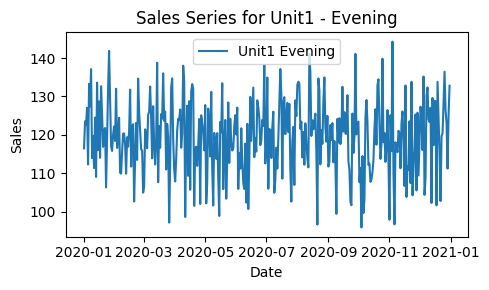

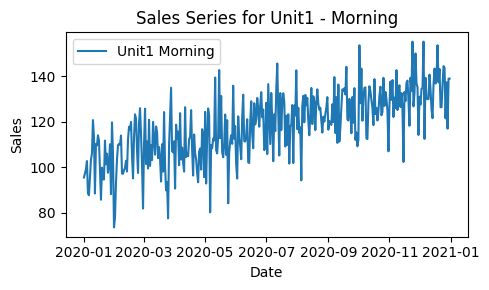

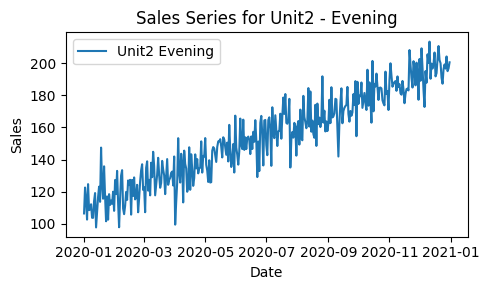

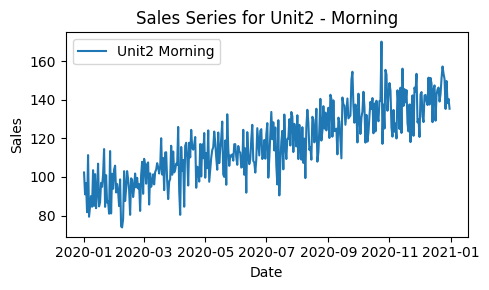

In [6]:
# plot the series

# Group by Unit and Shift
groups = df.groupby(['Unit', 'Shift'])

# Loop through each group and plot the series
for (unit, shift), group in groups:
    plt.figure(figsize=(5, 3))
    plt.plot(group['Date'], group['Sales'], linestyle='-', label=f'{unit} {shift}')
    plt.title(f'Sales Series for {unit} - {shift}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [7]:
# create dummies
df = pd.get_dummies(df, columns = ['WeekdayName', 'HolidayYN'], drop_first=True)

In [8]:
exo_cols = ['WeekdayName_Monday','WeekdayName_Tuesday', 'WeekdayName_Wednesday', 'WeekdayName_Thursday',
            'WeekdayName_Saturday', 'WeekdayName_Sunday', 'HolidayYN_1']

In [9]:
# -------------------------------------------------------------
# Function to determine the non-seasonal differencing order (d)
# using the KPSS test. We increase d until the series becomes stationary.
# -------------------------------------------------------------
def determine_differencing_order(series, alpha=0.05, max_d=2):
    d = 0
    series_to_test = series.copy()
    while d <= max_d:
        try:
            statistic, p_value, n_lags, crit = kpss(series_to_test, regression='c', nlags="auto")
        except Exception as e:
            print(f"KPSS test error: {e}")
            break
        # If p_value > alpha, the series is stationary
        if p_value > alpha:
            break
        else:
            d += 1
            series_to_test = series_to_test.diff().dropna()
    return d

# -------------------------------------------------------------
# Function to determine the seasonal differencing order (D)
# using the nsdiffs function from pmdarima.
# -------------------------------------------------------------
def determine_seasonal_differencing_order(series, seasonal_period=7, max_D=1):
    D = nsdiffs(series, m=seasonal_period, max_D=max_D)
    return D

# -------------------------------------------------------------
# Function to create the difference dataframe.
# For each Unit/Shift series, calculate d and D.
# -------------------------------------------------------------
def create_difference_dataframe(df, seasonal_period=7):
    rows = []
    for (unit, shift), group in df.groupby(['Unit', 'Shift']):
        group = group.sort_values('Date')
        series = group['Sales'].astype(float)
        d = determine_differencing_order(series)
        D = determine_seasonal_differencing_order(series, seasonal_period)
        rows.append({
            'Unit': unit,
            'Shift': shift,
            'Difference': d,
            'SeasonalDifference': D
        })
    difference_df = pd.DataFrame(rows)
    return difference_df

# -------------------------------------------------------------
# Function to create the model parameters dataframe.
# It uses candidate lists for p, q, P, Q and the computed d and D values.
# -------------------------------------------------------------
def create_model_parameters_dataframe(difference_df, 
                                        p_values=[0,1,2], 
                                        q_values=[0,1,2], 
                                        P_values=[0,1], 
                                        Q_values=[0,1], 
                                        seasonal_period=7):
    rows = []
    for _, row in difference_df.iterrows():
        unit = row['Unit']
        shift = row['Shift']
        d = row['Difference']
        D = row['SeasonalDifference']
        model_number = 0
        # Generate all combinations of (p, q, P, Q)
        for p, q, P, Q in itertools.product(p_values, q_values, P_values, Q_values):
            model_number += 1
            # Build the SARIMAX parameter tuple:
            # non-seasonal order: (p, d, q)
            # seasonal order: (P, D, Q, seasonal_period)
            model_params = {
                'order': (p, d, q),
                'seasonal_order': (P, D, Q, seasonal_period)
            }
            rows.append({
                'Unit': unit,
                'Shift': shift,
                'ModelNumber': model_number,
                'ModelParameters': model_params
            })
    model_parameters_df = pd.DataFrame(rows)
    return model_parameters_df

In [10]:
df['Date'] = pd.to_datetime(df['Date'])
    
# 1. Create the difference dataframe
difference_df = create_difference_dataframe(df, seasonal_period=7)
    
# 2. Create the model parameters dataframe
model_parameters_df = create_model_parameters_dataframe(difference_df, p_values=[0,1], q_values=[0,1], 
                                                        P_values=[0], Q_values=[0], seasonal_period=7)

In [11]:

def create_testing_date_ranges_dataframe(df, forecast_lengths=[7, 90], periods=3, shift_days=11):
    """
    Create a DataFrame with testing date ranges for each unit/shift series.
    
    For each (Unit, Shift) group in the DataFrame:
      - For each forecast_length (e.g., 7 or 90 days), generate a fixed number of periods (default 3).
      - The first testing period ends on the maximum date in the series.
      - Subsequent periods are obtained by shifting the end date to the left by shift_days (11 days).
      - The start date is computed as end date - forecast_length + 1.
      
    Parameters:
      df: pandas DataFrame containing at least the 'Date', 'Unit', and 'Shift' columns.
      forecast_lengths: list of forecast lengths (in days) to create testing periods for.
      periods: number of testing periods to generate for each forecast length.
      shift_days: number of days to shift the testing period end date for each subsequent period.
    
    Returns:
      A pandas DataFrame with columns: Unit, Shift, TestingPeriodNumber, ForecastLength, StartDate, EndDate.
    """
    rows = []
    for (unit, shift), group in df.groupby(['Unit', 'Shift']):
        group = group.sort_values('Date')
        max_date = group['Date'].max()
        for forecast_length in forecast_lengths:
            for period in range(1, periods + 1):
                # Compute shift offset: period 1 uses 0-day offset, period 2 uses shift_days, etc.
                shift_offset = (period - 1) * shift_days
                period_end = max_date - pd.Timedelta(days=shift_offset)
                period_start = period_end - pd.Timedelta(days=forecast_length - 1)
                rows.append({
                    'Unit': unit,
                    'Shift': shift,
                    'TestingPeriodNumber': f"{forecast_length}_period_{period}",
                    'ForecastLength': forecast_length,
                    'StartDate': period_start,
                    'EndDate': period_end
                })
    testing_ranges_df = pd.DataFrame(rows)
    return testing_ranges_df

In [12]:
testing_ranges_df = create_testing_date_ranges_dataframe(df)

In [13]:
# -------------------------------------------------------------
# Utility function to compute error metrics.
# -------------------------------------------------------------
def compute_error_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    # Avoid division by zero in MAPE calculation:
    with np.errstate(divide='ignore', invalid='ignore'):
        mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1, y_true))) * 100
    return mae, mape, rmse

# -------------------------------------------------------------
# Function to run model testing and collect the results.
#
# For each (Unit, Shift) group:
#  1. For each testing period (defined by forecast_start and forecast_end)
#     - Use all data before forecast_start as the training set.
#     - Extract actual sales for the testing period.
#  2. For each candidate model (from the model_parameters_df):
#     - Fit a SARIMAX model on the training set.
#     - Forecast for forecast_length days.
#     - Compute MAE, MAPE, and RMSE comparing the forecast to the actual test data.
#  3. Append the results to a list.
#
# Returns a DataFrame with columns:
#   Unit, Shift, ForecastLength, ForecastStart, ForecastEnd,
#   ModelParameters (string), MAE, MAPE, RMSE
# -------------------------------------------------------------
def run_sarima_testing(df, testing_date_ranges_df, model_parameters_df):
    results = []
    
    # Loop over each testing period from our testing ranges dataframe.
    for _, test_row in testing_date_ranges_df.iterrows():
        unit = test_row['Unit']
        shift = test_row['Shift']
        forecast_start = test_row['StartDate']
        forecast_end = test_row['EndDate']
        forecast_length = test_row['ForecastLength']
        
        # Extract and sort data for the current unit and shift.
        group_data = df[(df['Unit'] == unit) & (df['Shift'] == shift)].sort_values('Date')
        # Set Date as the index and enforce a daily frequency
        group_data = group_data.set_index('Date').asfreq('D')
        
        # Use all available data before the forecast start date as training.
        train_data = group_data[group_data.index < forecast_start]
        exo_train = group_data[exo_cols]
        # Extract test data for the forecast period.
        test_data = group_data[(group_data.index >= forecast_start) & (group_data.index <= forecast_end)]
        exo_test = group_data[exo_cols]
        
        # Ensure we have a complete test period.
        if len(test_data) < forecast_length or train_data.empty:
            print(f"Skipping Unit {unit} Shift {shift} period starting {forecast_start} due to insufficient data.")
            continue

        # Get candidate models for the current unit/shift.
        models_df = model_parameters_df[(model_parameters_df['Unit'] == unit) & (model_parameters_df['Shift'] == shift)]
        
        for _, model_row in models_df.iterrows():
            model_params = model_row['ModelParameters']
            order = model_params['order']
            seasonal_order = model_params['seasonal_order']
            
            try:
                # Fit SARIMAX on training data.
                model = SARIMAX(train_data['Sales'],
                                order=order, 
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
                model_fit = model.fit(disp=False, maxiter=200, method='lbfgs')
                
                # Forecast the specified number of steps.
                forecast = model_fit.forecast(steps=forecast_length)
                
                # Ensure forecast and test data lengths match.
                if len(forecast) != forecast_length:
                    print(f"Forecast length mismatch for Unit {unit} Shift {shift} with model {model_params}")
                    continue
                
                # Calculate error metrics.
                mae, mape, rmse = compute_error_metrics(test_data['Sales'].values[:forecast_length], forecast.values)
                
                # Format the model parameters as a string (e.g., "(1,0,0)x(1,0,0,7)")
                model_param_str = f"({order[0]},{order[1]},{order[2]})x({seasonal_order[0]},{seasonal_order[1]},{seasonal_order[2]},{seasonal_order[3]})"
                
                results.append({
                    'Unit': unit,
                    'Shift': shift,
                    'ForecastLength': forecast_length,
                    'ForecastStart': forecast_start,
                    'ForecastEnd': forecast_end,
                    'ModelParameters': model_param_str,
                    'MAE': mae,
                    'MAPE': mape,
                    'RMSE': rmse
                })
            except Exception as e:
                # In case the model fails to fit, log and continue.
                print(f"Error for Unit {unit} Shift {shift} with model {model_params}: {e}")
                continue
    
    # Convert results list into a DataFrame.
    results_df = pd.DataFrame(results)
    return results_df

In [14]:
def run_sarimax_testing(df, testing_date_ranges_df, model_parameters_df, exo_cols):
    """
    For each (Unit, Shift) and test period, fits SARIMAX with exogenous variables.
    Uses the columns in exo_cols as exogenous regressors.
    Returns a DataFrame of results.
    """

    results = []
    
    for _, test_row in testing_date_ranges_df.iterrows():
        unit = test_row['Unit']
        shift = test_row['Shift']
        forecast_start = test_row['StartDate']
        forecast_end = test_row['EndDate']
        forecast_length = test_row['ForecastLength']

        # Extract and sort data for the current unit and shift.
        group_data = df[(df['Unit'] == unit) & (df['Shift'] == shift)].sort_values('Date').copy()
        group_data = group_data.set_index('Date').asfreq('D')
        
        # Use all available data before the forecast start date as training.
        train_data = group_data[group_data.index < forecast_start]
        test_data = group_data[(group_data.index >= forecast_start) & (group_data.index <= forecast_end)]

        if len(test_data) < forecast_length or train_data.empty:
            print(f"Skipping Unit {unit} Shift {shift} period starting {forecast_start} due to insufficient data.")
            continue

        # Get candidate models for the current unit/shift.
        models_df = model_parameters_df[(model_parameters_df['Unit'] == unit) & (model_parameters_df['Shift'] == shift)]
        
        for _, model_row in models_df.iterrows():
            model_params = model_row['ModelParameters']
            order = model_params['order']
            seasonal_order = model_params['seasonal_order']

            # Prepare exogenous data for training and forecasting
            train_exog = train_data[exo_cols] if exo_cols else None
            test_exog = test_data[exo_cols] if exo_cols else None

            try:
                # Fit SARIMAX with exogenous variables
                model = SARIMAX(
                    train_data['Sales'], 
                    exog=train_exog, 
                    order=order, 
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                model_fit = model.fit(disp=False, maxiter=200, method='lbfgs')
                
                # Forecast the specified number of steps, passing exogenous variables for the forecast period
                forecast = model_fit.forecast(steps=forecast_length, exog=test_exog)
                
                if len(forecast) != forecast_length:
                    print(f"Forecast length mismatch for Unit {unit} Shift {shift} with model {model_params}")
                    continue

                # Calculate error metrics
                y_true = test_data['Sales'].values[:forecast_length]
                y_pred = forecast.values
                mae = mean_absolute_error(y_true, y_pred)
                rmse = np.sqrt(mean_squared_error(y_true, y_pred))
                with np.errstate(divide='ignore', invalid='ignore'):
                    mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1, y_true))) * 100

                model_param_str = f"({order[0]},{order[1]},{order[2]})x({seasonal_order[0]},{seasonal_order[1]},{seasonal_order[2]},{seasonal_order[3]})"
                results.append({
                    'Unit': unit,
                    'Shift': shift,
                    'ForecastLength': forecast_length,
                    'ForecastStart': forecast_start,
                    'ForecastEnd': forecast_end,
                    'ModelParameters': model_param_str,
                    'MAE': mae,
                    'MAPE': mape,
                    'RMSE': rmse
                })
            except Exception as e:
                print(f"Error for Unit {unit} Shift {shift} with model {model_params}: {e}")
                continue

    return pd.DataFrame(results)

In [15]:
def run_xgboost_testing(df, testing_date_ranges_df, exo_cols, xgb_params=None):
    """
    For each (Unit, Shift) and test period, fits XGBoost with lag_1 + exo_cols as features, 
    rolls 1-step ahead through the test period, and records error metrics.
    
    Args:
        df: Main DataFrame (should contain Date, Unit, Shift, Sales, and all exogenous columns in exo_cols).
        testing_date_ranges_df: DataFrame with test period info.
        exo_cols: List of exogenous column names (dummies, one-hots, etc.), already created in df.
        xgb_params: Dict of XGBoost hyperparameters (optional).
    
    Returns:
        DataFrame with Unit, Shift, ForecastLength, ForecastStart, ForecastEnd, ModelName, MAE, MAPE, RMSE.
    """

    results = []
    if xgb_params is None:
        xgb_params = {'objective': 'reg:squarederror', 'n_estimators': 100, 'max_depth': 3}
    
    for _, test_row in testing_date_ranges_df.iterrows():
        unit = test_row['Unit']
        shift = test_row['Shift']
        forecast_start = test_row['StartDate']
        forecast_end = test_row['EndDate']
        forecast_length = test_row['ForecastLength']

        # Filter and sort for this group
        group_data = df[(df['Unit'] == unit) & (df['Shift'] == shift)].sort_values('Date').copy()

        # Create lag_1 feature
        group_data['lag_1'] = group_data['Sales'].shift(1)

        # Drop NA introduced by lag_1 (important for training)
        group_data = group_data.dropna(subset=['lag_1'])

        features = ['lag_1'] + exo_cols

        # Split train/test
        train_data = group_data[group_data['Date'] < forecast_start].copy()
        test_data = group_data[(group_data['Date'] >= forecast_start) & (group_data['Date'] <= forecast_end)].copy()

        # If not enough data, skip
        if len(test_data) < forecast_length or train_data.empty:
            print(f"Skipping Unit {unit} Shift {shift} period starting {forecast_start} due to insufficient data.")
            continue

        # XGBoost expects no missing values
        train_X = train_data[features]
        train_y = train_data['Sales']

        try:
            model = xgb.XGBRegressor(**xgb_params)
            model.fit(train_X, train_y)
        except Exception as e:
            print(f"Error fitting XGBoost for Unit {unit} Shift {shift}: {e}")
            continue

        # Rolling forecast for the test period
        preds = []
        # Start lag_1 with the last training value
        last_lag = train_data.iloc[-1]['Sales']
        for i in range(forecast_length):
            # Prepare feature row for current test step
            row = test_data.iloc[i].copy()
            row['lag_1'] = last_lag if i == 0 else preds[-1]
            X_pred = row[features].values.reshape(1, -1)
            pred = model.predict(X_pred)[0]
            preds.append(pred)

        # Compute errors
        y_true = test_data['Sales'].values[:forecast_length]
        y_pred = np.array(preds)
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        with np.errstate(divide='ignore', invalid='ignore'):
            mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1, y_true))) * 100

        results.append({
            'Unit': unit,
            'Shift': shift,
            'ForecastLength': forecast_length,
            'ForecastStart': forecast_start,
            'ForecastEnd': forecast_end,
            'ModelName': f'XGBoost_lag1_{len(features)}feats',
            'MAE': mae,
            'MAPE': mape,
            'RMSE': rmse
        })

    return pd.DataFrame(results)

In [16]:
def run_xgboost_testing_exog_only(df, testing_date_ranges_df, exo_cols, xgb_params=None):
    """
    For each (Unit, Shift) and test period, fits XGBoost using only exogenous variables (no lag).
    Predicts the whole test period at once since all features are known.
    Returns DataFrame with error metrics per test.
    """

    results = []
    if xgb_params is None:
        xgb_params = {'objective': 'reg:squarederror', 'n_estimators': 100, 'max_depth': 3}
    
    for _, test_row in testing_date_ranges_df.iterrows():
        unit = test_row['Unit']
        shift = test_row['Shift']
        forecast_start = test_row['StartDate']
        forecast_end = test_row['EndDate']
        forecast_length = test_row['ForecastLength']

        # Filter and sort for this group
        group_data = df[(df['Unit'] == unit) & (df['Shift'] == shift)].sort_values('Date').copy()

        # Train/test split
        train_data = group_data[group_data['Date'] < forecast_start].copy()
        test_data = group_data[(group_data['Date'] >= forecast_start) & (group_data['Date'] <= forecast_end)].copy()

        # If not enough data, skip
        if len(test_data) < forecast_length or train_data.empty:
            print(f"Skipping Unit {unit} Shift {shift} period starting {forecast_start} due to insufficient data.")
            continue

        train_X = train_data[exo_cols]
        train_y = train_data['Sales']
        test_X = test_data[exo_cols]
        y_true = test_data['Sales'].values[:forecast_length]

        try:
            model = xgb.XGBRegressor(**xgb_params)
            model.fit(train_X, train_y)
            y_pred = model.predict(test_X)
        except Exception as e:
            print(f"Error fitting XGBoost for Unit {unit} Shift {shift}: {e}")
            continue

        # Compute errors
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        with np.errstate(divide='ignore', invalid='ignore'):
            mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1, y_true))) * 100

        results.append({
            'Unit': unit,
            'Shift': shift,
            'ForecastLength': forecast_length,
            'ForecastStart': forecast_start,
            'ForecastEnd': forecast_end,
            'ModelName': f'XGBoost_exog_only_{len(exo_cols)}feats',
            'MAE': mae,
            'MAPE': mape,
            'RMSE': rmse
        })

    return pd.DataFrame(results)


In [17]:
def run_naive_testing(df, testing_date_ranges_df):
    """
    For each (Unit, Shift) and test period, fits mean, median, and last-value naive models.
    Returns a DataFrame with error metrics per test/model.
    """
    
    results = []
    model_names = ['Mean', 'Median', 'LastValue']

    for _, test_row in testing_date_ranges_df.iterrows():
        unit = test_row['Unit']
        shift = test_row['Shift']
        forecast_start = test_row['StartDate']
        forecast_end = test_row['EndDate']
        forecast_length = test_row['ForecastLength']

        # Filter and sort for this group
        group_data = df[(df['Unit'] == unit) & (df['Shift'] == shift)].sort_values('Date').copy()

        # Train/test split
        train_data = group_data[group_data['Date'] < forecast_start].copy()
        test_data = group_data[(group_data['Date'] >= forecast_start) & (group_data['Date'] <= forecast_end)].copy()

        if len(test_data) < forecast_length or train_data.empty:
            print(f"Skipping Unit {unit} Shift {shift} period starting {forecast_start} due to insufficient data.")
            continue

        y_true = test_data['Sales'].values[:forecast_length]
        train_sales = train_data['Sales'].values

        naive_forecasts = {
            'Mean': np.mean(train_sales),
            'Median': np.median(train_sales),
            'LastValue': train_sales[-1] if len(train_sales) > 0 else np.nan
        }

        for model_name in model_names:
            y_pred = np.full(forecast_length, naive_forecasts[model_name])

            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            with np.errstate(divide='ignore', invalid='ignore'):
                mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1, y_true))) * 100

            results.append({
                'Unit': unit,
                'Shift': shift,
                'ForecastLength': forecast_length,
                'ForecastStart': forecast_start,
                'ForecastEnd': forecast_end,
                'ModelName': model_name,
                'MAE': mae,
                'MAPE': mape,
                'RMSE': rmse
            })

    return pd.DataFrame(results)

In [18]:
sarima_testing_results = run_sarima_testing(df, testing_ranges_df, model_parameters_df)
sarimax_testing_results = run_sarimax_testing(df, testing_ranges_df, model_parameters_df, exo_cols)
xgb_testing_results = run_xgboost_testing(df, testing_ranges_df, exo_cols)
xgb_no_lag_testing_results = run_xgboost_testing_exog_only(df, testing_ranges_df, exo_cols)
naive_testing_results = run_naive_testing(df, testing_ranges_df)

In [19]:
naive_testing_results.head()

,Unit,Shift,ForecastLength,ForecastStart,ForecastEnd,ModelName,MAE,MAPE,RMSE
0,Unit1,Evening,7,2020-12-25,2020-12-31,Mean,9.168855,7.166882,10.128871
1,Unit1,Evening,7,2020-12-25,2020-12-31,Median,8.834453,6.914738,9.818369
2,Unit1,Evening,7,2020-12-25,2020-12-31,LastValue,8.427790,6.608108,9.458276
3,Unit1,Evening,7,2020-12-14,2020-12-20,Mean,9.745835,8.066036,10.929998
4,Unit1,Evening,7,2020-12-14,2020-12-20,Median,9.550392,7.933033,10.766202


In [20]:
sarima_testing_results.head()

,Unit,Shift,ForecastLength,ForecastStart,ForecastEnd,ModelParameters,MAE,MAPE,RMSE
0,Unit1,Evening,7,2020-12-25,2020-12-31,"(0,0,0)x(0,0,0,7)",126.165417,100.000000,126.385911
1,Unit1,Evening,7,2020-12-25,2020-12-31,"(0,0,1)x(0,0,0,7)",120.623723,95.678037,121.520533
2,Unit1,Evening,7,2020-12-25,2020-12-31,"(1,0,0)x(0,0,0,7)",10.217620,7.944873,11.252711
3,Unit1,Evening,7,2020-12-25,2020-12-31,"(1,0,1)x(0,0,0,7)",9.940760,7.748798,10.888583
4,Unit1,Evening,7,2020-12-14,2020-12-20,"(0,0,0)x(0,0,0,7)",123.414283,100.000000,123.828670


In [21]:
sarimax_testing_results.head()

,Unit,Shift,ForecastLength,ForecastStart,ForecastEnd,ModelParameters,MAE,MAPE,RMSE
0,Unit1,Evening,7,2020-12-25,2020-12-31,"(0,0,0)x(0,0,0,7)",24.273037,18.955435,46.647526
1,Unit1,Evening,7,2020-12-25,2020-12-31,"(0,0,1)x(0,0,0,7)",24.274915,18.956875,46.647756
2,Unit1,Evening,7,2020-12-25,2020-12-31,"(1,0,0)x(0,0,0,7)",24.273762,18.956022,46.646755
3,Unit1,Evening,7,2020-12-25,2020-12-31,"(1,0,1)x(0,0,0,7)",11.871054,9.196118,13.320146
4,Unit1,Evening,7,2020-12-14,2020-12-20,"(0,0,0)x(0,0,0,7)",21.393178,19.583402,39.365841


In [22]:
xgb_testing_results.head()

,Unit,Shift,ForecastLength,ForecastStart,ForecastEnd,ModelName,MAE,MAPE,RMSE
0,Unit1,Evening,7,2020-12-25,2020-12-31,XGBoost_lag1_8feats,8.416716,6.555561,9.396955
1,Unit1,Evening,7,2020-12-14,2020-12-20,XGBoost_lag1_8feats,8.977691,7.384129,10.283115
2,Unit1,Evening,7,2020-12-03,2020-12-09,XGBoost_lag1_8feats,9.186952,7.868452,10.755152
3,Unit1,Evening,90,2020-10-03,2020-12-31,XGBoost_lag1_8feats,9.683687,8.434343,12.016116
4,Unit1,Evening,90,2020-09-22,2020-12-20,XGBoost_lag1_8feats,9.450821,8.226276,11.648615


In [23]:
xgb_no_lag_testing_results.head()

,Unit,Shift,ForecastLength,ForecastStart,ForecastEnd,ModelName,MAE,MAPE,RMSE
0,Unit1,Evening,7,2020-12-25,2020-12-31,XGBoost_exog_only_7feats,10.940392,8.508190,12.763695
1,Unit1,Evening,7,2020-12-14,2020-12-20,XGBoost_exog_only_7feats,8.836256,7.330100,10.183532
2,Unit1,Evening,7,2020-12-03,2020-12-09,XGBoost_exog_only_7feats,10.830890,8.988797,11.763535
3,Unit1,Evening,90,2020-10-03,2020-12-31,XGBoost_exog_only_7feats,8.789915,7.609509,10.685059
4,Unit1,Evening,90,2020-09-22,2020-12-20,XGBoost_exog_only_7feats,8.771386,7.659676,10.687205
